In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix,
    classification_report, f1_score, recall_score, precision_score)
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [2]:
# Reads a CSV file named 'renewal_data_after_log_transformation.csv' from the specified relative path 
lgb_renewal_df = pd.read_csv('../_data/renewal_data_after_log_transformation.csv')

# Converts the 'customer_id' column in the DataFrame to string type. 
# Then, pad each value in the column with leading zeros to ensure that all values are 8 characters long.
lgb_renewal_df['customer_id'] = lgb_renewal_df['customer_id'].astype(str).str.zfill(8)

In [3]:
# Define the target column for prediction and a list of columns with low importance to be excluded
target_col = 'member_renewed_indicator'

# Define the feature matrix (X) by dropping the target column, customer ID, and low-importance columns
# Define the target variable (y) as the target column
X = lgb_renewal_df.drop(columns=[target_col, 'customer_id'])
y = lgb_renewal_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Initialize the LightGBM classifier with a random state for reproducibility
model = LGBMClassifier(random_state= 42,
                       subsample= 0.6,
                       reg_lambda= 2.0,
                       reg_alpha= 2.0,
                       num_leaves= 40,
                       n_estimators= 400,
                       min_data_in_leaf= 20,
                       min_child_samples= 70,
                       max_depth= 5,
                       learning_rate= 0.025, 
                       feature_fraction= 1.0,
                       colsample_bytree= 0.8,
                       bagging_fraction= 1.0)
model.fit(X_train, y_train)
# Make predictions on the test set
threshold = 0.6  # set the threshold here

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Apply threshold
y_pred_custom = (y_prob >= threshold).astype(int)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.6 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.6 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 3105, number of negative: 2810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

In [53]:
"""# Save the model to a file
with open('lgbm_YL_v1_model.pkl', 'wb') as file:
    pickle.dump(model, file)"""

Accuracy: 0.7382
Precision: 0.8507
ROC AUC: 0.8557
F1 Score: 0.7090
Recall: 0.6078
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.88      0.76      1205
         1.0       0.85      0.61      0.71      1331

    accuracy                           0.74      2536
   macro avg       0.76      0.74      0.74      2536
weighted avg       0.77      0.74      0.73      2536



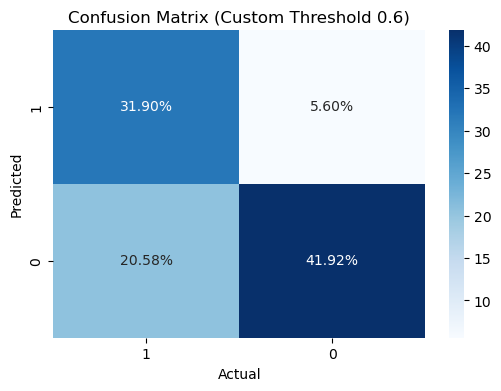

In [4]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_custom):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_custom):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_custom):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_custom))

# Custom threshold confusion matrix
reorder = [1, 0]
conf_matrix_custom = confusion_matrix(y_test, y_pred_custom)
total_custom = conf_matrix_custom.sum()
cm_percent_custom = (conf_matrix_custom/ total_custom) * 100
conf_matrix_custom_reordered = cm_percent_custom.T[reorder, :][:, reorder]
plt.figure(figsize=(6, 4))
annot_custom = np.vectorize(lambda x: f"{x:.2f}%")(conf_matrix_custom_reordered)
sns.heatmap(conf_matrix_custom_reordered, annot=annot_custom, fmt='', cmap='Blues',
            xticklabels=[1, 0], yticklabels=[1, 0])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix (Custom Threshold 0.6)')
plt.show()

In [5]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

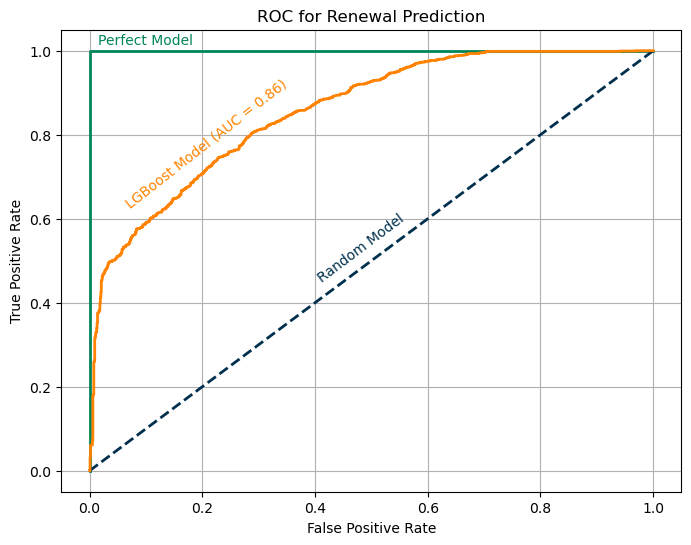

In [97]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot([0, 0, 1], [0, 1, 1], color='#008558', lw=2, label='Perfect Model')
plt.plot([0, 1], [0, 1], color='#00304d', lw=2, linestyle='--', label='Random Model')
plt.plot(fpr, tpr, color='#ff8200', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.text(fpr[1] + 0.06, tpr[1] + 0.625, f'LGBoost Model (AUC = {roc_auc:.2f})', color='#ff8200', rotation=38)
plt.text(0.4, 0.45, 'Random Model', color='#00304d', rotation=37)
plt.text(0.015, 1.015, 'Perfect Model', color='#008558')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Renewal Prediction')
#plt.legend(loc='lower right')
plt.grid(True)
plt.show()